## **U-NET Implementation**

In [22]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torcheval.metrics.functional import peak_signal_noise_ratio

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import cv2

## **Task 1**

Build a general U-Net model.

In [23]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlock(in_channels, out_channels),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.decoder(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderNoSkip, self).__init__()
        self.decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU()
        )
        self.conv = ConvBlock(out_channels*2, out_channels)

    def forward(self, x):
        x = self.decoder(x)
        x = self.conv(x)
        return x

class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = Decoder(features[4], features[3])
        self.decoder2 = Decoder(features[3], features[2])
        self.decoder3 = Decoder(features[2], features[1])
        self.decoder4 = Decoder(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x1 = self.in_conv1(x)
        x1 = self.in_conv2(x1)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        x = self.out_conv1(x)

        return x

class UNet_NoSkip(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(UNet_NoSkip, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = DecoderNoSkip(features[4], features[3])
        self.decoder2 = DecoderNoSkip(features[3], features[2])
        self.decoder3 = DecoderNoSkip(features[2], features[1])
        self.decoder4 = DecoderNoSkip(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        x = self.out_conv1(x)

        return x


## **Task 2**

Train super-resolution U-Net model.

In [24]:
# NOTE: LOCAL DEVICE ONLY!. 
# check and change dir if needed
os.chdir('E:/projects/unet-learn/') if os.getcwd() != 'E:/projects/unet-learn/' else None
os.getcwd()

'E:\\projects\\unet-learn'

In [25]:
TRAIN_PATH = 'dataset/train/'
VAL_PATH = 'dataset/val/'

BATCH_SIZE = 4
LOW_WIDTH = 64
LOW_HEIGHT = 64

torch.manual_seed(42)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.resize = transforms.Resize((LOW_HEIGHT, LOW_WIDTH), antialias=True)
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)
    
    def normalize(self, input_img, target_img):
        input_img = input_img*2 - 1
        target_img = target_img*2 - 1

        return input_img, target_img
    
    def random_jitter(self, input_img, target_img):
        if torch.rand([]) < 0.5:
            input_img = transforms.functional.hflip(input_img)
            target_img = transforms.functional.hflip(target_img)

        # if torch.rand([]) < 0.5:
        #     input_img = torch.flip(input_img, [2])
        #     target_img = torch.flip(target_img, [2])

        return input_img, target_img
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        img = transforms.functional.to_tensor(img)

        input_img = self.resize(img).type(torch.float32)
        target_img = img.type(torch.float32)

        input_img, target_img = self.normalize(input_img, target_img)

        if self.is_train:
            input_img, target_img = self.random_jitter(input_img, target_img)

        return input_img, target_img

In [6]:
train_dataset = ImageDataset(TRAIN_PATH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageDataset(VAL_PATH, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

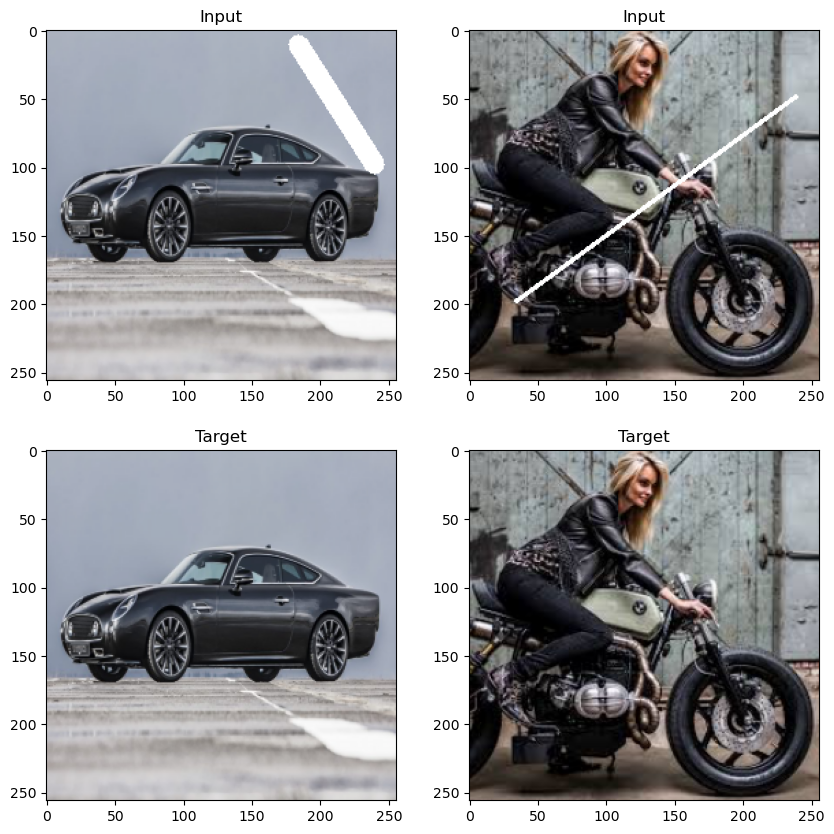

In [26]:
def visualize_dataset():
    in_batch, tar_batch = next(iter(train_loader))
    in_batch = (in_batch + 1)/2
    tar_batch = (tar_batch + 1)/2

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(np.squeeze(in_batch[0].numpy().transpose((1, 2, 0))))
    plt.title("Input")
    ax = plt.subplot(2, 2, 3)
    plt.imshow(np.squeeze(tar_batch[0].numpy().transpose((1, 2, 0))))
    plt.title("Target")
    ax = plt.subplot(2, 2, 2)
    plt.imshow(np.squeeze(in_batch[1].numpy().transpose((1, 2, 0))))
    plt.title("Input")
    ax = plt.subplot(2, 2, 4)
    plt.imshow(np.squeeze(tar_batch[1].numpy().transpose((1, 2, 0))))
    plt.title("Target")

visualize_dataset()

#### Train SR Model

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
class SR_UNet(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(SR_UNet, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_HEIGHT*4, LOW_WIDTH*4), antialias=True)

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = Decoder(features[4], features[3])
        self.decoder2 = Decoder(features[3], features[2])
        self.decoder3 = Decoder(features[2], features[1])
        self.decoder4 = Decoder(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x = self.resize_fnc(x)
        x1 = self.in_conv1(x)
        x1 = self.in_conv2(x1)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        x = self.out_conv1(x)

        return x

class SR_UNet_NoSkip(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(SR_UNet_NoSkip, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_HEIGHT*4, LOW_WIDTH*4), antialias=True)

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = DecoderNoSkip(features[4], features[3])
        self.decoder2 = DecoderNoSkip(features[3], features[2])
        self.decoder3 = DecoderNoSkip(features[2], features[1])
        self.decoder4 = DecoderNoSkip(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        x = self.out_conv1(x)

        return x

In [10]:
unet_model = SR_UNet().to(device)
img = torch.ones(2, 3, LOW_HEIGHT, LOW_WIDTH).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

In [30]:
def generate_images(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
    inputs, labels, predictions = inputs.cpu().numpy(), labels.cpu().numpy(), predictions.cpu().numpy()
    plt.figure(figsize=(15,20))

    display_list = [inputs[-1].transpose((1, 2, 0)), labels[-1].transpose((1, 2, 0)), predictions[-1].transpose((1, 2, 0))]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [31]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0,
                log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(predictions, labels)
        total_count += 1
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| psnr {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0
            start_time = time.time()

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [32]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())


            total_psnr +=  peak_signal_noise_ratio(predictions, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [33]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_psnr, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_psnrs.append(train_psnr.cpu())
        train_losses.append(train_loss)

        # Evaluation
        eval_psnr, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_psnrs.append(eval_psnr.cpu())
        eval_losses.append(eval_loss)

        # Save best model
        if best_psnr_eval < eval_psnr :
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            inputs_t, targets_t = next(iter(valid_dataloader))
            generate_images(model, inputs_t, targets_t)
            best_psnr_eval = eval_psnr
        times.append(time.time() - epoch_start_time)
        # Print loss, psnr end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

### **Plot Result**

In [35]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_psnrs, eval_psnrs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_psnrs, label = "Training")
    axs[0].plot(epochs, eval_psnrs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("PSNR")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [34]:
import matplotlib.pyplot as plt

def predict_and_display(model, test_dataloader, device):
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            if idx >= 10:
                break
            inputs = inputs.to(device)
            predictions = model(inputs)
            generate_images(model, inputs, labels)
            plt.show()


### **UNet No Skip**

In [18]:
unet_model = SR_UNet_NoSkip().to(device)
img = torch.ones(2, 3, LOW_HEIGHT, LOW_WIDTH).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

In [50]:
import torch.optim as optim

model = UNet_NoSkip().to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

save_model = './UnetNoSkip'
os.makedirs(save_model, exist_ok=True)

### **UNet with Skip**

In [42]:
unet_model = SR_UNet().to(device)
img = torch.ones(2, 3, LOW_HEIGHT, LOW_WIDTH).to(device)
unet_model(img).shape

torch.Size([2, 3, 64, 64])

In [43]:
import torch.optim as optim

model = SR_UNet().to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

save_model = './Unet'
os.makedirs(save_model, exist_ok=True)

### **Train**

In [ ]:
EPOCHS = 10
model, metrics = train(model, 'UnetNoSkip', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device)

## **Task 3**

In-painting U-Net model.

In [14]:
HEIGHT = 256
WIDTH = 256

In [20]:
class II_UNet(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(II_UNet, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = Decoder(features[4], features[3])
        self.decoder2 = Decoder(features[3], features[2])
        self.decoder3 = Decoder(features[2], features[1])
        self.decoder4 = Decoder(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x1 = self.in_conv1(x)
        x1 = self.in_conv2(x1)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        x = self.out_conv1(x)

        return x

class II_UNet_NoSkip(nn.Module):
    def __init__(self, n_channel=3, n_classes=3, features=[64, 128, 256, 512, 1024]):
        super(II_UNet_NoSkip, self).__init__()

        self.n_channel = n_channel
        self.n_classes = n_classes

        self.in_conv1 = FirstFeature(n_channel, features[0])
        self.in_conv2 = ConvBlock(features[0], features[0])

        self.encoder1 = Encoder(features[0], features[1])
        self.encoder2 = Encoder(features[1], features[2])
        self.encoder3 = Encoder(features[2], features[3])
        self.encoder4 = Encoder(features[3], features[4])

        self.decoder1 = DecoderNoSkip(features[4], features[3])
        self.decoder2 = DecoderNoSkip(features[3], features[2])
        self.decoder3 = DecoderNoSkip(features[2], features[1])
        self.decoder4 = DecoderNoSkip(features[1], features[0])

        self.out_conv1 = FinalOutput(features[0], n_classes)

    def forward(self, x):
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        x = self.out_conv1(x)

        return x

In [28]:
ii_unet_model = II_UNet().to(device)
img = torch.ones(2, 3, HEIGHT, WIDTH).to(device)
ii_unet_model(img).shape


torch.Size([2, 3, 256, 256])

In [29]:
ii_unet_model_noskip = II_UNet_NoSkip().to(device)
img = torch.ones(2, 3, HEIGHT, WIDTH).to(device)
ii_unet_model_noskip(img).shape

torch.Size([2, 3, 256, 256])

### **Dataset Prep**

In [11]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def normalize(self, input_image, target_image):
        input_image  = input_image*2 - 1
        target_image = target_image*2 - 1

        return input_image, target_image

    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image

    def create_mask(self, image):
        masked_image = image.copy()
        ## Prepare masking matrix
        mask = np.full((WIDTH,HEIGHT,3), 0, np.uint8)
        for _ in range(np.random.randint(1, 5)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, WIDTH), np.random.randint(1, WIDTH)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, HEIGHT), np.random.randint(1, HEIGHT)
            # Get random thickness of the line drawn
            thickness = np.random.randint(1, 15)
            # Draw line on the black mask
            cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

        masked_image = np.where(mask, 255*np.ones_like(mask), masked_image)
        return masked_image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = np.array(Image.open(img_path).convert("RGB"))

        input_image = self.create_mask(image)
        input_image = transforms.functional.to_tensor(input_image)
        target_image = transforms.functional.to_tensor(image)

        input_image = input_image.type(torch.float32)
        target_image = target_image.type(torch.float32)

        input_image, target_image = self.normalize(input_image, target_image)

        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image

In [12]:
train_dataset = ImageDataset(TRAIN_PATH, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageDataset(VAL_PATH, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

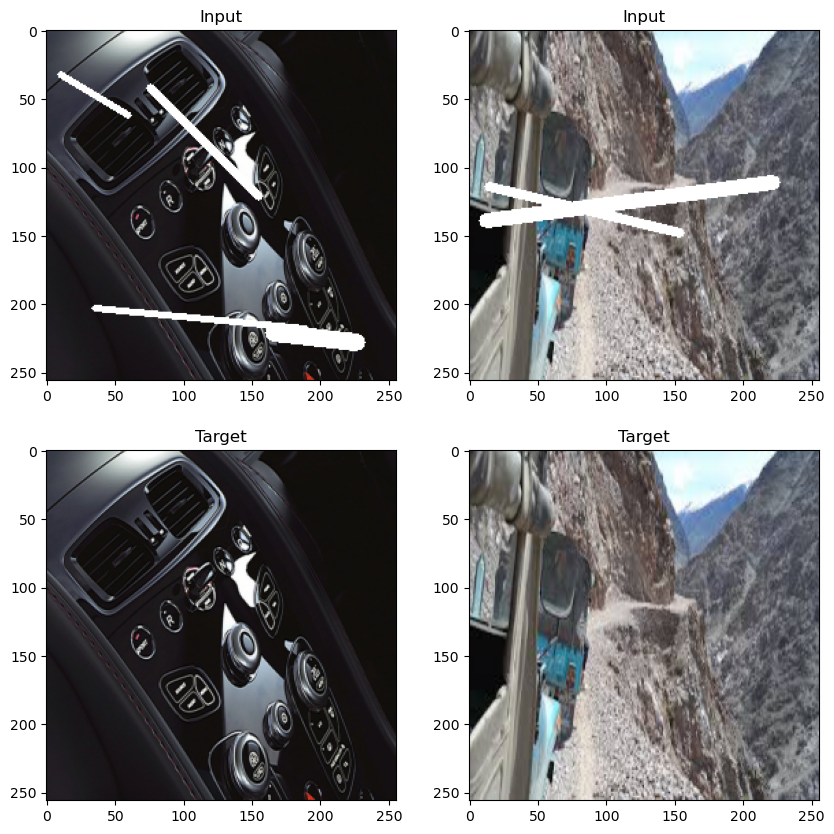

In [18]:
visualize_dataset()

### **Train In-painting Model**

#### **Inpainting No Skip**

In [36]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ii_unet_model_noskip = II_UNet_NoSkip().to(device)
ii_unet_model_noskip.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(ii_unet_model_noskip.parameters(), lr=1e-4, betas=(0.5, 0.999))

save_model = './iiUnetNoSkip'
os.makedirs(save_model, exist_ok=True)

In [ ]:
EPOCHS = 10

ii_unet_model_noskip, metrics = train(ii_unet_model_noskip, 'iiUnetNoSkip', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device)

#### **Inpainting Skip**

In [37]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ii_unet_model = II_UNet().to(device)
ii_unet_model.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(ii_unet_model.parameters(), lr=1e-4, betas=(0.5, 0.999))

save_model = './iiUnet'
os.makedirs(save_model, exist_ok=True)

In [ ]:
EPOCHS = 10
ii_unet_model, metrics = train(ii_unet_model, 'iiUnet', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device)